In [ ]:
#data directly used from kaggle
!pip install kaggle
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muhammetzahitaydn/hardhat-vest-dataset-v3
! mkdir train
! unzip hardhat-vest-dataset-v3.zip -d hardhat-vest-dataset-v3

In [ ]:
!pip install ultralytics==8.0.20

In [ ]:
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 34.9/107.7 GB disk)


In [ ]:
from ultralytics import yolo
from IPython.display import display, Image
import yaml, os, cv2, glob
import matplotlib.pyplot as plt
from ultralytics import YOLO
import numpy as np

In [ ]:
#read the text file that contains class name
with open('/content/hardhat-vest-dataset-v3/labels/classes.txt', 'r') as f:
  clss = f.read()
f.close()
helmet_cls = clss.split('\n')[:-1]
helmet_cls

['helmet', 'vest', 'head', 'person']

In [ ]:
#build the .yaml file
data_dict = {'train' : '/content/hardhat-vest-dataset-v3/images/train',
             'val'   : '/content/hardhat-vest-dataset-v3/images/val',
             'test'  : '/content/hardhat-vest-dataset-v3/images/test',
             'names'  : helmet_cls,
             'nc'    : len(helmet_cls)
}
with open('/content/hardhat-vest-dataset-v3/data.yaml', 'w+') as f:
  yaml.dump(data_dict, f)
f.close()

In [ ]:
#checking number of files present in each train, validation, test folders
clss_idx = {str(i):helmet_cls[i] for i in range(len(helmet_cls))}
clss_start, data_len = {}, {}
for mode in ['train', 'val', 'test']:
  clss_count = {helmet_cls[i]:0 for i in range(len(helmet_cls))}
  label_path = '/content/hardhat-vest-dataset-v3/labels/'+mode
  for f in os.listdir(label_path):
    with open(os.path.join(label_path, f)) as f_lbl:
      lines = f_lbl.readlines()
      for clss_num in set([line[0] for line in lines]):
        clss_count[clss_idx[clss_num]] += 1
  data_len[mode] = len(label_path)
  clss_start[mode] = clss_count

data_len, clss_start

({'train': 45, 'val': 43, 'test': 44},
 {'train': {'helmet': 12333, 'vest': 3096, 'head': 5810, 'person': 0},
  'val': {'helmet': 1782, 'vest': 406, 'head': 712, 'person': 0},
  'test': {'helmet': 1822, 'vest': 440, 'head': 713, 'person': 0}})

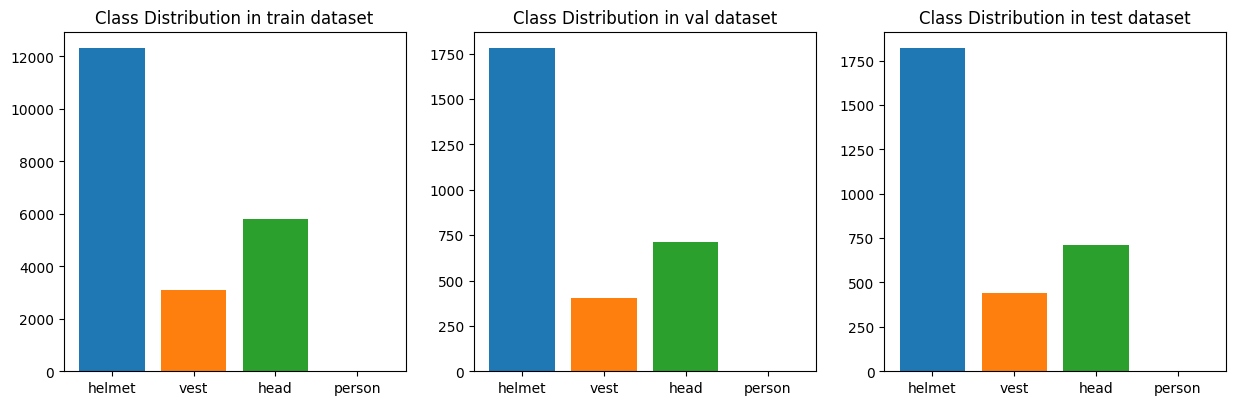

In [ ]:
i=1
plt.figure(figsize=(15, 15))
for mode in ['train', 'val', 'test']:
  plt.subplot(3, 3, i)
  for keys, value in clss_start[mode].items():
    plt.bar(keys, value)
  plt.title('Class Distribution in '+mode+' dataset')
  i+=1

In [ ]:
#check the dataset present in each mode
img_path = '/content/hardhat-vest-dataset-v3/images/'
data_len = {mode:len(os.listdir(img_path+mode)) for mode in ['train', 'val', 'test']}
data_len

{'train': 17248, 'val': 2438, 'test': 2455}

In [ ]:
#check image size in each mode
img_size = (0, 0, 0)
for mode in ['train', 'val', 'test']:
  count=0
  for f in glob.glob(os.path.join(img_path, mode, '*')):
    try:
      img_s = cv2.imread(f).shape
      if img_s != img_size:
        print(img_s, img_size, f)
        img_size = img_s
    except:
      count+=1
  print(mode, count)

(640, 640, 3) (0, 0, 0) /content/hardhat-vest-dataset-v3/images/train/a03130.jpg
train 0
val 0
test 0


In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
#training the model
model = YOLO('yolov8n.pt')
model.train(data = '/content/hardhat-vest-dataset-v3/data.yaml',
            task = 'detect',
            imgsz = 640,
            epochs = 15,
            batch = 16,
            mode = 'train',
            name = 'yolo8n_v1_train')

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/hardhat-vest-dataset-v3/data.yaml, epochs=15, patience=50, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=yolo8n_v1_train, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynam

In [ ]:
#trained model
model1 = YOLO('/content/hardhat-vest-dataset-v3/best.pt')
#model2 = YOLO('/content/runs/detect/yolo8n_v1_train2/weights/best.pt')

In [ ]:
#testing on all image
test_path = '/content/hardhat-vest-dataset-v3/images/test'
results = model.predict(source=test_path, save=True)

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients, 8.1 GFLOPs
Results saved to runs/detect/yolo8n_v1_train4


In [ ]:
#output of 10 images choosen randomly
pred_file = glob.glob(os.path.join('/content/runs/detect/yolo8n_v1_train4', '*'))
for i in range(10):
  idx = np.random.randint(0, len(pred_file))
  img = cv2.imread(pred_file[idx])
  plt.imshow(img)
  plt.axis('off')
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
results

[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([6, 6])
 dtype: torch.float32
  + tensor([[444.00000,  60.00000, 507.00000, 154.00000,   0.91410,   2.00000],
         [515.00000, 113.00000, 556.00000, 187.00000,   0.90985,   2.00000],
         [128.00000, 131.00000, 164.00000, 187.00000,   0.81228,   2.00000],
         [199.00000, 102.00000, 234.00000, 157.00000,   0.76557,   2.00000],
         [323.00000, 126.00000, 353.00000, 177.00000,   0.76166,   2.00000],
         [414.00000, 108.00000, 448.00000, 166.00000,   0.75852,   2.00000]])]